In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks import *

In [3]:
torch.cuda.is_available()

True

In [4]:
np.random.seed(42)

In [5]:
tfms = get_transforms(do_flip=True,flip_vert=False,max_rotate=10.0,max_zoom=1.2,max_lighting=0.5,max_warp=0.2,p_affine=0.75,p_lighting=0.75)


In [6]:
mixup=0.2

In [7]:
loss_func = LabelSmoothingCrossEntropy()

In [8]:
# class FocalLoss(nn.Module):
#     def __init__(self, alpha=1., gamma=1.):
#         super().__init__()
#         self.alpha = alpha
#         self.gamma = gamma

#     def forward(self, inputs, targets, **kwargs):
#         CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
#         pt = torch.exp(-CE_loss)
#         F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
#         return F_loss.mean()
# loss_func = FocalLoss(gamma=2.5)

In [9]:
alpha=0.99
mom=0.9
eps=1e-6

In [10]:
opt_func = partial(optim.Adam, betas=(mom,alpha), eps=eps)

In [11]:
src = (ImageList.from_folder(path='train').split_by_rand_pct(0.2).label_from_folder())

In [12]:
data = src.transform(tfms,size=(640)).databunch(bs=24).normalize()

In [13]:
learn = cnn_learner(data, models.densenet121,pretrained=False, metrics=[error_rate, accuracy, FBeta(beta=1,average='macro')],loss_func = loss_func,opt_func=opt_func,wd=1e-2)

/home/ubuntu/anaconda3/envs/snakes_breed/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [14]:
learn= learn.mixup(alpha=mixup)

In [15]:
learn.bn_wd=False

In [16]:
learn.true_wd=True

In [17]:
learn.load('exp-11-round-1')

Learner(data=ImageDataBunch;

Train: LabelList (65934 items)
x: ImageList
Image (3, 640, 640),Image (3, 640, 640),Image (3, 640, 640),Image (3, 640, 640),Image (3, 640, 640)
y: CategoryList
class-857,class-857,class-857,class-857,class-857
Path: train;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 640, 640),Image (3, 640, 640),Image (3, 640, 640),Image (3, 640, 640),Image (3, 640, 640)
y: CategoryList
class-540,class-526,class-771,class-4,class-804
Path: train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [18]:
learn.TTA(ds_type=DatasetType.Valid)

(tensor([[-1.5636, -2.1078, -1.6897,  ..., -1.4202, -1.5796, -0.0499],
         [-1.2703, -0.9975, -1.6707,  ..., -0.9332, -1.6254, -1.3745],
         [ 2.6232, -0.9215, -1.0293,  ..., -0.3299, -1.7468, -0.8200],
         ...,
         [-2.1704, -2.1987, -0.8867,  ...,  0.0458, -2.2436, -2.3878],
         [ 0.0439,  1.1616,  1.0917,  ...,  2.7376,  0.2056,  0.1447],
         [-0.0753,  2.0721,  0.0492,  ...,  1.4234, -0.0577,  0.4174]]),
 tensor([19, 17, 35,  ..., 11,  4, 31]))

In [19]:
interp = ClassificationInterpretation.from_learner(learn)


In [20]:
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

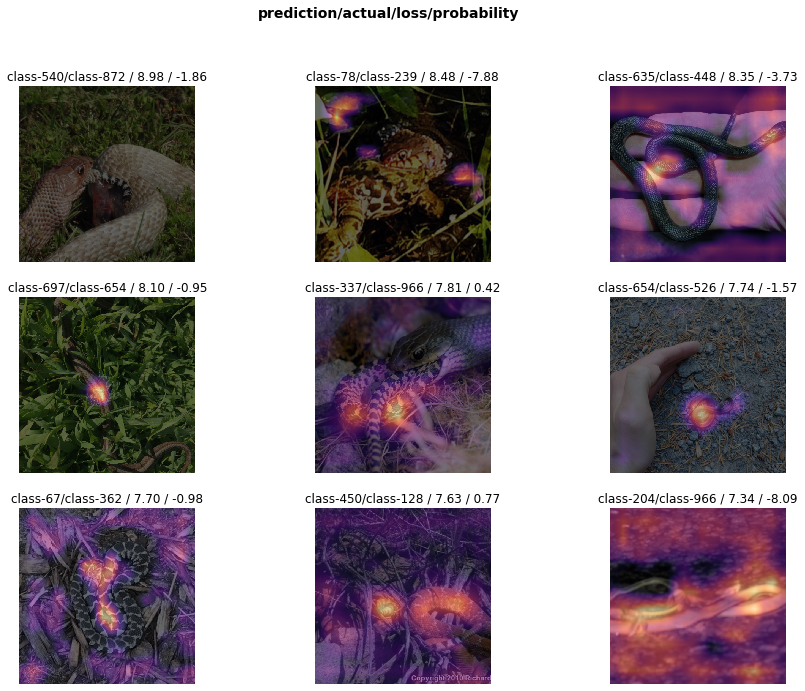

In [21]:
interp.plot_top_losses(9, figsize=(15,11))


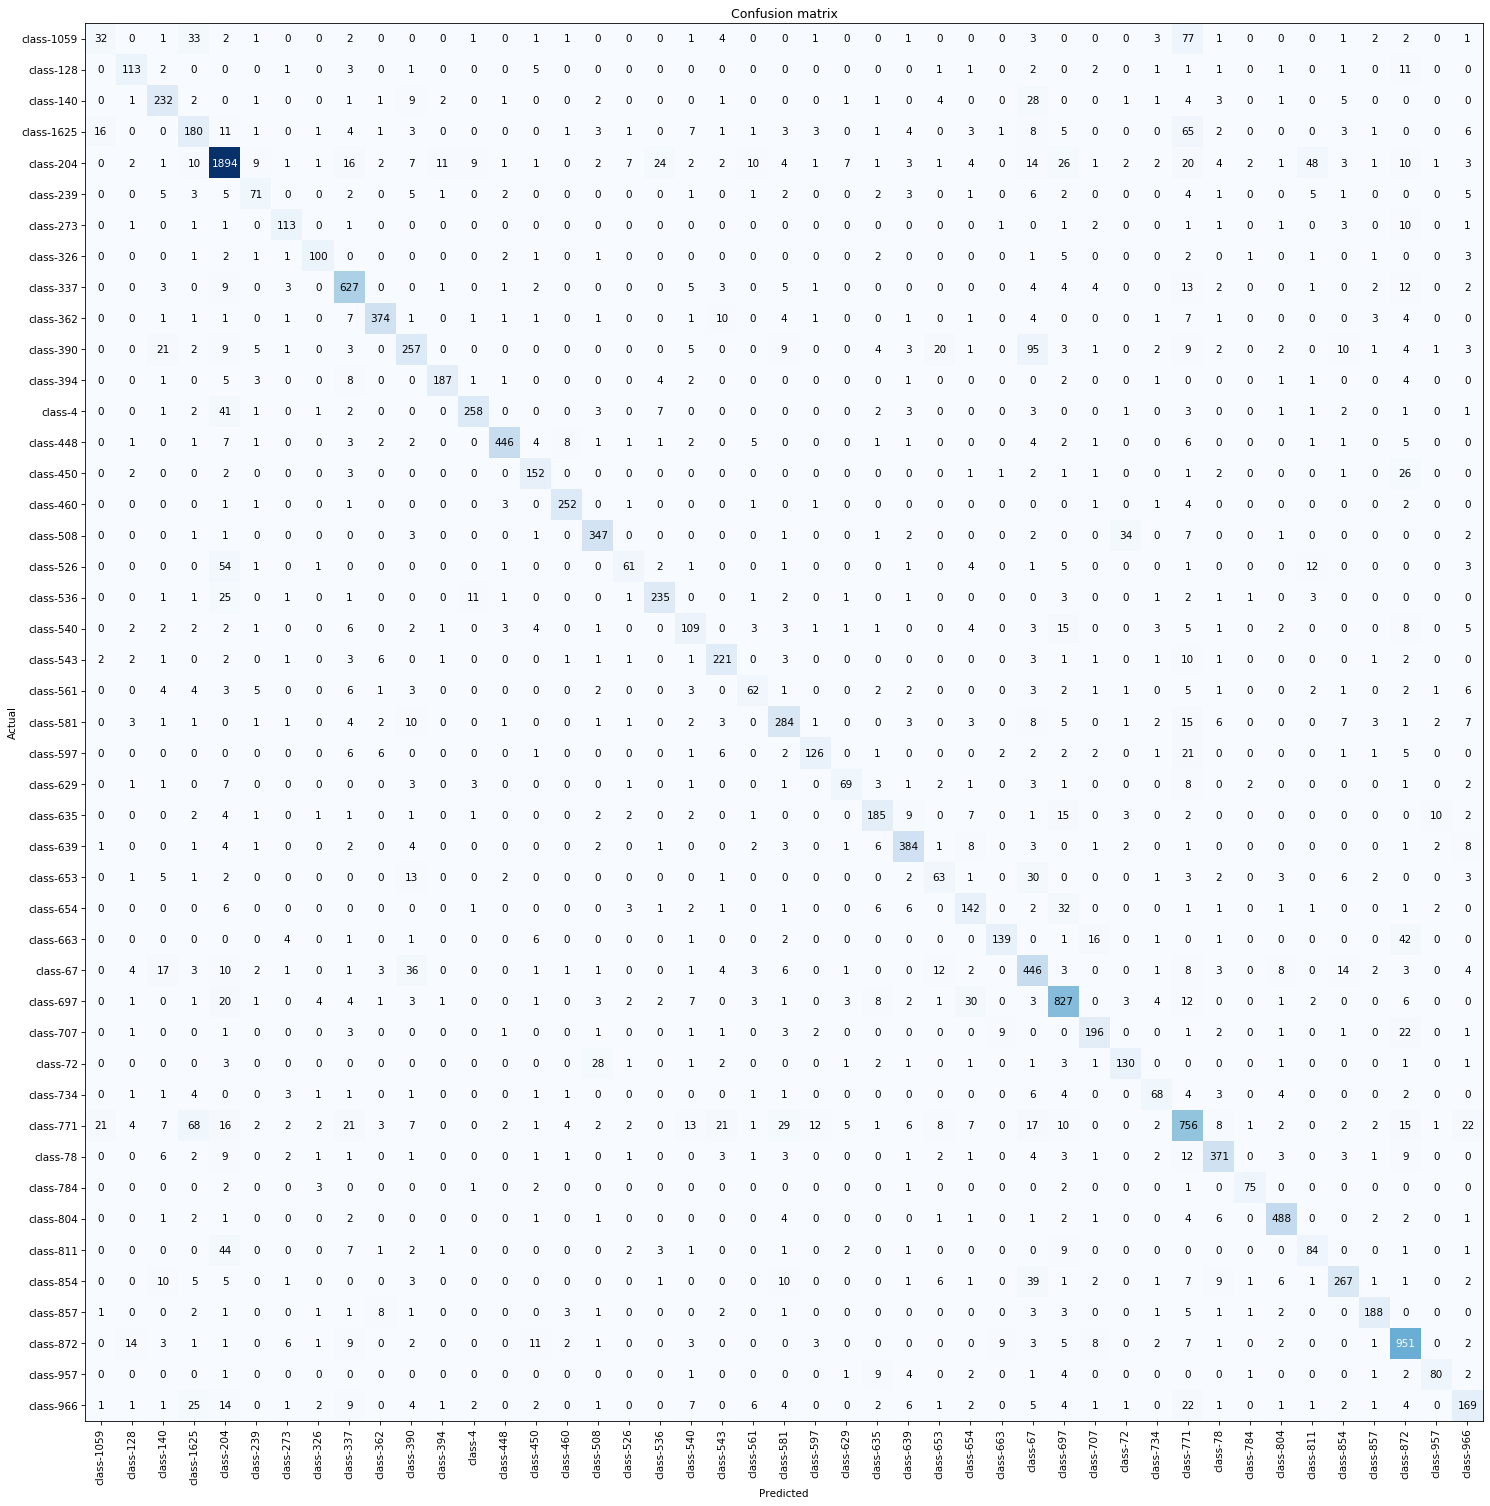

In [22]:
interp.plot_confusion_matrix(figsize=(20,20), dpi=75)


In [23]:
interp.most_confused(min_val=2)


[('class-390', 'class-67', 95),
 ('class-1059', 'class-771', 77),
 ('class-771', 'class-1625', 68),
 ('class-1625', 'class-771', 65),
 ('class-526', 'class-204', 54),
 ('class-204', 'class-811', 48),
 ('class-811', 'class-204', 44),
 ('class-663', 'class-872', 42),
 ('class-4', 'class-204', 41),
 ('class-854', 'class-67', 39),
 ('class-67', 'class-390', 36),
 ('class-508', 'class-72', 34),
 ('class-1059', 'class-1625', 33),
 ('class-654', 'class-697', 32),
 ('class-653', 'class-67', 30),
 ('class-697', 'class-654', 30),
 ('class-771', 'class-581', 29),
 ('class-140', 'class-67', 28),
 ('class-72', 'class-508', 28),
 ('class-204', 'class-697', 26),
 ('class-450', 'class-872', 26),
 ('class-536', 'class-204', 25),
 ('class-966', 'class-1625', 25),
 ('class-204', 'class-536', 24),
 ('class-707', 'class-872', 22),
 ('class-771', 'class-966', 22),
 ('class-966', 'class-771', 22),
 ('class-390', 'class-140', 21),
 ('class-597', 'class-771', 21),
 ('class-771', 'class-1059', 21),
 ('class-771

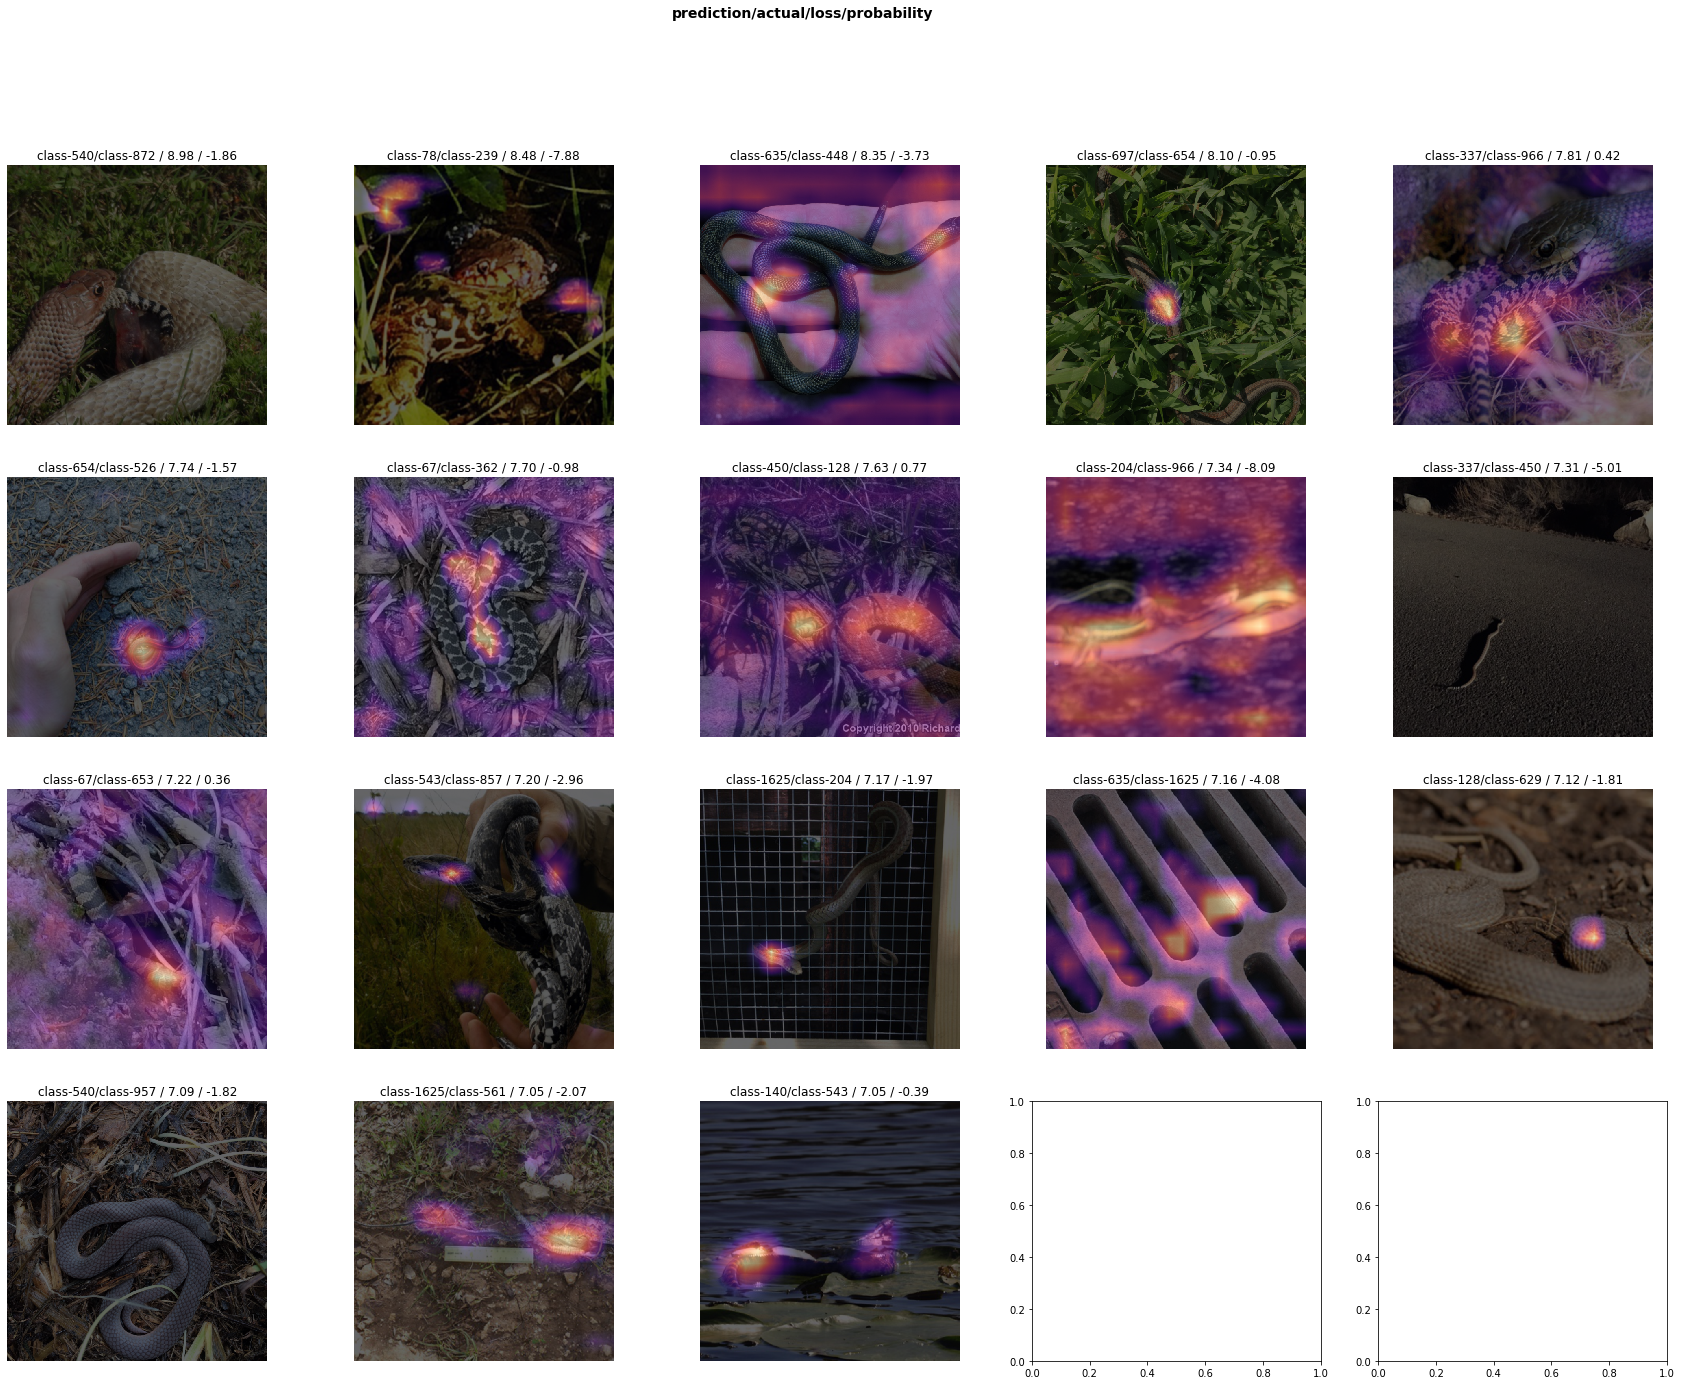

In [26]:
interp.plot_top_losses(18, figsize=(30,22))